# Определение уровня английского языка

## Знакомство с данными

Загружаем библиотеки

In [1]:
import pandas as pd
import xlrd
from os.path import join
from pathlib import Path
import os
import magic
import pysrt 
import chardet
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from tqdm import notebook
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator

Теперь загрузим субтитры

In [3]:
PATH = "C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all"

In [4]:
##sub_folders = ['A2','B1','B2','C1','Subtitles']

Получим список всех адресов субтитров

In [5]:
all_files = []
for root, dirs, files in os.walk(PATH):
    #print(root, dirs, files)
    if len(dirs) == 0:
        for f in files:
            if f[-4:] == '.srt':
                all_files.append(os.path.join(root,f))

In [6]:
all_files

['C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\A2\\The Walking Dead-S01E01-Days Gone Bye.English.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\A2\\The Walking Dead-S01E02-Guts.English.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\A2\\The Walking Dead-S01E03-Tell It To The Frogs.English.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\A2\\The Walking Dead-S01E04-Vatos.English.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\A2\\The Walking Dead-S01E05-Wildfire.English.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\A2\\The Walking Dead-S01E06-TS-19.English.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\B1\\AmericanBeauty1999.BRRip.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\B1\\Angelas.Christmas.Wish.2020.srt',
 'C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitle

Список получен

Теперь добавим субтитры в датафрейм и "раскодируем" их.

In [7]:
%%time
m = magic.Magic(mime_encoding=True)
df = pd.DataFrame([])
for r in all_files:
    #base_encoding = 'utf-8'
    open_for_encode = open(r,'rb').read()
    enc = m.from_buffer(open_for_encode)
    if enc == 'unknown-8bit':
        enc = 'cp1251'
    if enc == 'binary':
        enc = 'utf-8'
    data = pysrt.open(r, encoding=enc)
    df0 = pd.DataFrame([[r,data,enc]])
    df = pd.concat([df,df0])
df.columns = ['path','raw_data','encoding']

CPU times: total: 12.2 s
Wall time: 12.3 s


Теперь добавим столбец с разметкой из папок.

In [8]:
def level_folder(x):
    if '\\A2\\' in x:
        return 'A2'
    if '\\B1\\' in x:
        return 'B1'
    if '\\B2\\' in x:
        return 'B2'
    if '\\C1\\' in x:
        return 'C1'
    else:
        return None

In [9]:
df['level_from_folder'] = df['path'].apply(lambda x: level_folder(x)) 

Добавим функции для очистки "адреса", чтобы оставить одно название фильма.

In [10]:
def clean_row(x):
    return x.removeprefix('C:\\Users\\79099\\Desktop\\Workshop\\English_level\\Subtitles_all\\') 

In [11]:
def clean_row_1(x):
    if 'A2\\' in x:
        return x.removeprefix('A2\\')
    if 'B2\\' in x:
        return x.removeprefix('B2\\')
    if 'B1\\' in x:
        return x.removeprefix('B1\\')
    if 'C1\\' in x:
        return x.removeprefix('C1\\')
    if 'Subtitles\\' in x:
        return x.removeprefix('Subtitles\\')


In [12]:
def clean_row_2(x):
    return x.removesuffix('.srt')


In [13]:
df['path'] = df['path'].apply(lambda x: clean_row(x)) 

In [14]:
df['path'] = df['path'].apply(lambda x: clean_row_1(x)) 

In [15]:
df['path'] = df['path'].apply(lambda x: clean_row_2(x)) 

In [16]:
df.head(5)

,path,raw_data,encoding,level_from_folder
0,The Walking Dead-S01E01-Days Gone Bye.English,"[1\n00:00:03,169 --> 00:00:05,171\n( bugs chit...",utf-8,A2
0,The Walking Dead-S01E02-Guts.English,"[1\n00:00:03,045 --> 00:00:05,047\n- ( birds c...",utf-8,A2
0,The Walking Dead-S01E03-Tell It To The Frogs.E...,"[1\n00:00:03,003 --> 00:00:04,671\n( thunder r...",utf-8,A2
0,The Walking Dead-S01E04-Vatos.English,"[1\n00:00:03,045 --> 00:00:05,422\n( birds chi...",utf-8,A2
0,The Walking Dead-S01E05-Wildfire.English,"[1\n00:00:03,420 --> 00:00:04,922\n- ( walkie-...",utf-8,A2


Получили датафрейм с субтитрами.

Теперь откроем размеченную таблицу в эксель.

In [17]:
dp = Path("C:/Users/79099/Desktop/Workshop/English_level") 

In [18]:
df_ex = pd.read_excel(join(dp, 'movies_labels.xlsx'))

In [19]:
df_ex

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+
...,...,...,...
236,236,Matilda(2022),C1
237,237,Bullet train,B1
238,238,Thor: love and thunder,B2
239,239,Lightyear,B2


Объеденим таблицы по ключу "Movie" название фильма.

In [20]:
df = df.rename(columns={'path': 'Movie'})

In [21]:
data = pd.merge(df_ex, df, how="inner", on=['Movie'])

In [22]:
data.head(5)

,id,Movie,Level,raw_data,encoding,level_from_folder
0,0,10_Cloverfield_lane(2016),B1,"[1\n00:00:55,279 --> 00:01:07,279\n<font color...",us-ascii,None
1,1,10_things_I_hate_about_you(1999),B1,"[1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n...",us-ascii,None
2,2,A_knights_tale(2001),B2,"[1\n00:00:15,089 --> 00:00:21,229\nResync: Xen...",us-ascii,None
3,3,A_star_is_born(2018),B2,"[1\n00:00:17,610 --> 00:00:22,610\n- <i><font ...",utf-8,None
4,4,Aladdin(1992),A2/A2+,"[1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co...",utf-8,None


**Вывод**

Подготовили данные к дальнейшей работе.

## Анализ данных

Посмотрим как распределяются фильмы по уровню сложности английского языка.

In [23]:
data['Level'].value_counts()

B2            97
B1            53
C1            39
A2/A2+        25
B1, B2         8
A2             6
A2/A2+, B1     5
Name: Level, dtype: int64

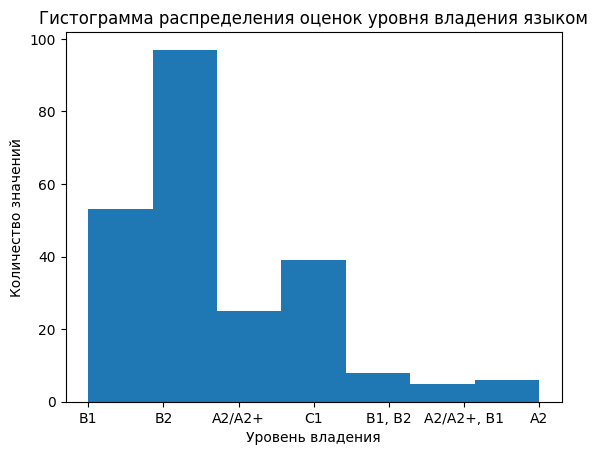

In [24]:
plt.hist(data['Level'], bins=7)
plt.title('Гистограмма распределения оценок уровня владения языком')
plt.xlabel('Уровень владения')
plt.ylabel('Количество значений')
plt.show()

Как мы видим у нас есть не четко размеченые уровни. Приведём все уровни к четырём категориям: A, B1, B2 и C.

In [25]:
data['Level'] = data['Level'].replace('A2/A2+', 'A')
data['Level'] = data['Level'].replace('A2', 'A')
data['Level'] = data['Level'].replace('A2/A2+, B1', 'A')
data['Level'] = data['Level'].replace('B1, B2', 'B1')

In [26]:
data['Level'].value_counts()

B2    97
B1    61
C1    39
A     36
Name: Level, dtype: int64

In [27]:
data['Level'].value_counts(normalize=True)

B2    0.416309
B1    0.261803
C1    0.167382
A     0.154506
Name: Level, dtype: float64

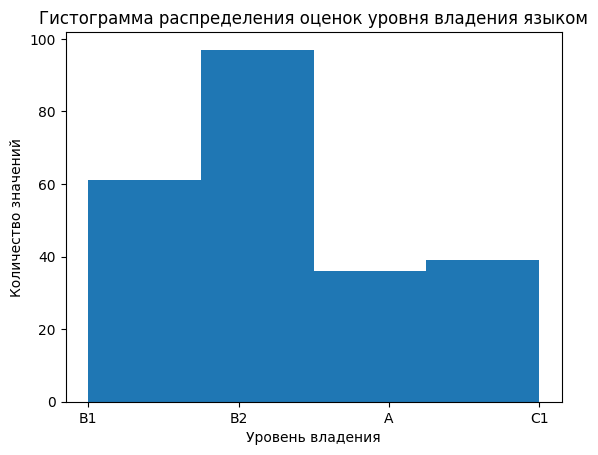

In [28]:
plt.hist(data['Level'], bins=4)
plt.title('Гистограмма распределения оценок уровня владения языком')
plt.xlabel('Уровень владения')
plt.ylabel('Количество значений')
plt.show()

**Вывод**

Распределение фильмов по уровню сложности английского языка выглядит следующим образом:
- B2 -  41.6%
- B1 - 26.18%
- C1 - 16.7%
- A  - 15.4%


## Подготовка данных

Сначало уберём столбцы, которые будут не нужны в дальнейшем.

In [29]:
data = data.drop(columns=['encoding', 'level_from_folder', 'id'])

In [30]:
data.head(5)

,Movie,Level,raw_data
0,10_Cloverfield_lane(2016),B1,"[1\n00:00:55,279 --> 00:01:07,279\n<font color..."
1,10_things_I_hate_about_you(1999),B1,"[1\n00:01:54,281 --> 00:01:55,698\nHey!\n, 2\n..."
2,A_knights_tale(2001),B2,"[1\n00:00:15,089 --> 00:00:21,229\nResync: Xen..."
3,A_star_is_born(2018),B2,"[1\n00:00:17,610 --> 00:00:22,610\n- <i><font ..."
4,Aladdin(1992),A,"[1\n00:00:27,240 --> 00:00:30,879\n<i>Oh, I co..."


Теперь объеденим субтитры в единый текст.

In [31]:
def text(x):
    return x.text

In [32]:
data['raw_data'] = data['raw_data'].apply(lambda x: text(x))

Почистим текст.

In [33]:
def clear_text(text):
   
    r_text = re.sub(r'[^a-zA-Z]', ' ', text)
    text_list = r_text.split()
    clear_text = " ".join(text_list)
    return clear_text

In [34]:
data['clean_text'] = data['raw_data'].apply(clear_text)

Проведём лемматизацию текста.

In [35]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\79099\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\79099\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79099\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [37]:
def lemmatize_words(text):
    word_list = nltk.word_tokenize(text)
    
    words = [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in word_list]
    return  ' '.join(words)


In [38]:
data['lemm_text'] = data['clean_text'].apply(lemmatize_words)

In [40]:
data.head(5)

,Movie,Level,raw_data,clean_text,lemm_text
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz...",font color ffff b Fixed Synced by bozxphd Enjo...,font color ffff b Fixed Synced by bozxphd Enjo...
1,10_things_I_hate_about_you(1999),B1,"Hey!\nI'll be right with you.\nSo, Cameron. He...",Hey I ll be right with you So Cameron Here you...,Hey I ll be right with you So Cameron Here you...
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL\nShould we help hi...,Resync Xenzai NEF RETAIL Should we help him He...,Resync Xenzai NEF RETAIL Should we help him He...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct...",i font color ffffff Synced and corrected by fo...,i font color ffffff Synced and correct by font...
4,Aladdin(1992),A,"<i>Oh, I come from a land\nFrom a faraway plac...",i Oh I come from a land From a faraway place i...,i Oh I come from a land From a faraway place i...


## Обучение моделей

Разделим данные на тренировочную и тестовую выборки.

In [41]:
nltk.download('stopwords')
stop_words = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79099\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
features = data['lemm_text']
target = data['Level']

In [44]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

Создадим класс Switcher

In [47]:
class ClfSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = SGDClassifier(),
    ):

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

Обучаем модель.

In [48]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', ClfSwitcher()),
])

In [49]:
parameters = [
    {
        'clf__estimator': [SGDClassifier()], 
        'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
        'tfidf__stop_words': ['english', None],
        'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
        'clf__estimator__max_iter': [50, 80],
        'clf__estimator__tol': [1e-4],
        'clf__estimator__loss': ['hinge', 'log', 'modified_huber'],
    },
    {
        'clf__estimator': [MultinomialNB()],
        'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
        'tfidf__stop_words': [None],
        'clf__estimator__alpha': (1e-2, 1e-3, 1e-1),
    },
]

In [50]:
gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, scoring='accuracy', verbose=3)
gscv.fit(features_train, target_train)

Fitting 5 folds for each of 156 candidates, totalling 780 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', ClfSwitcher())]),
             n_jobs=12,
             param_grid=[{'clf__estimator': [SGDClassifier()],
                          'clf__estimator__loss': ['hinge', 'log',
                                                   'modified_huber'],
                          'clf__estimator__max_iter': [50, 80],
                          'clf__estimator__penalty': ('l2', 'elasticnet', 'l1'),
                          'clf__estimator__tol': [0.0001],
                          'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
                          'tfidf__stop_words': ['english', None]},
                         {'clf__estimator': [MultinomialNB(alpha=0.01)],
                          'clf__estimator__alpha': (0.01, 0.001, 0.1),
                          'tfidf__max_df': (0.25, 0.5, 0.75, 1.0),
                          'tfidf__stop_words': [None]}],
             scor

In [51]:
print('Best parameter set: %s ' % gscv.best_params_)
print('CV Accuracy: %.3f' % gscv.best_score_)

Best parameter set: {'clf__estimator': MultinomialNB(alpha=0.01), 'clf__estimator__alpha': 0.01, 'tfidf__max_df': 0.25, 'tfidf__stop_words': None} 
CV Accuracy: 0.673


In [52]:
model = gscv.best_estimator_

Протестируем лучшую модель

In [53]:
print('Test Accuracy: %.3f' % model.score(features_test, target_test))

Test Accuracy: 0.574
